In [1]:
from google.colab import files
uploaded = files.upload()    #RatingData.csv  and T1T2CommunityCoresTrusses.csv  #NodeAttributesWithSubCommunityGC.csv NodeAttributesWithSubCommunity.csv
                              #Trying with ReverseOrder-T1T2CommunityCoresTrusses.csv

Saving RatingData.csv to RatingData.csv
Saving T1T2CommunityCoresTrusses.csv to T1T2CommunityCoresTrusses.csv


In [2]:
import pandas as pd
import numpy as np
import random
import math

In [3]:
NodeAttributesWithSubCommunity= pd.read_csv("T1T2CommunityCoresTrusses.csv")   # T1T2CommunityCoresTrusses.csv NodeAttributesWithSubCommunity.csv   NodeAttributesWithSubCommunityGC.csv
NodeAttributesWithSubCommunity.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)   #There was an unamed column in the file, needed to delete that column
NodeAttributesWithSubCommunity.drop(["a"], axis=1, inplace=True)

print(NodeAttributesWithSubCommunity.loc[NodeAttributesWithSubCommunity['UserID']==196])
#print("Total nodes are:", NodeAttributesWithSubCommunity['UserID'].count())
#NodeAttributesWithSubCommunity['ComWithSubCom'] = NodeAttributesWithSubCommunity['ComWithSubCom'].astype('string')
#NodeAttributesWithSubCommunity['SubCommunity'] = NodeAttributesWithSubCommunity['SubCommunity'].astype('string')
#NodeAttributesWithSubCommunity['Community'] = NodeAttributesWithSubCommunity['Community'].astype('string')
NodeAttributesWithSubCommunity


     UserID  Community  ...  T2TrussinCommunity  ComWithSubCom
195     196          0  ...                 128              0

[1 rows x 8 columns]


,UserID,Community,T1CorenessinCommunity,T1TrussinCommunity,SubCommunity,T2CorenessinCommunity,T2TrussinCommunity,ComWithSubCom
0,1,0,25,26.0,0,127,128,0
1,2,1,38,26.0,0,53,54,10
2,3,0,25,39.0,1,122,122,1
3,4,0,25,26.0,1,122,122,1
4,5,1,38,39.0,1,49,50,11
...,...,...,...,...,...,...,...,...
938,939,7,58,39.0,0,54,55,70
939,940,2,43,137.0,0,58,59,20
940,941,3,136,70.0,0,108,109,30
941,942,7,29,69.0,1,104,105,71


In [4]:
#Creating groups of column names
UnNormalizedFeatures=['Age', 'Occupation',	'Zipcode',	'AgeGroup',	'State','NumMoviesWatched']
NumericFeatures = ['NormalizedAge']
#AllStates = pd.unique(NodeAttributesWithSubCommunity['State']).tolist()
#AllStates = [x for x in AllStates if str(x) != 'nan']
#AllOccupations = pd.unique(NodeAttributesWithSubCommunity['Occupation'])
AgeLabels = ['Teenager','Youth','MiddleAge','Senior','SuperSenior']
AllGenres= ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
             'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller',  'War', 'Western']
AllGenresRatings = []
for genre in AllGenres:
   AllGenresRatings.append(genre+'Rating')
AllGenresPreference = []
for genre in AllGenres:
   AllGenresPreference.append(genre+'Preference')   

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

CommunityLabel = 'ComWithSubCom'   #'Community'      #   #'Community'  

#columnsToKeep = ['UserID','T1CorenessinCommunity','T2CorenessinCommunity',CommunityLabel]
#UserCommunity = NodeAttributesWithSubCommunity[columnsToKeep]
#UserCommunity[CommunityLabel] = UserCommunity[CommunityLabel].astype('category')
#UserCommunity['Community'] = UserCommunity['Community'].astype('string')   #---> change here

UserCommunity = NodeAttributesWithSubCommunity
UserCommunity[CommunityLabel] = UserCommunity[CommunityLabel].astype('string')
print("Total nodes are:", UserCommunity['UserID'].count())
UserCommunity.tail()
#UserCommunity.info()
#print(UserCommunity.nunique())
#print('num na values: ',UserCommunity.isna().sum().sum())
#UserCommunity.ComWithSubCom.unique()

Total nodes are: 943


,UserID,Community,T1CorenessinCommunity,T1TrussinCommunity,SubCommunity,T2CorenessinCommunity,T2TrussinCommunity,ComWithSubCom
938,939,7,58,39.0,0,54,55,70
939,940,2,43,137.0,0,58,59,20
940,941,3,136,70.0,0,108,109,30
941,942,7,29,69.0,1,104,105,71
942,943,3,136,69.0,0,108,109,30


In [6]:
communityMembers = UserCommunity.groupby(CommunityLabel)['UserID'].apply(list).to_dict()
communitySizes = {key: len(value) for key, value in communityMembers.items()}

#grouped_df = grouped_df.agg({"UserID": "nunique"})
#grouped_df = grouped_df.reset_index()
#grouped_df = grouped_df[grouped_df.UserID > 5]  #discard groups with less than five users
#grouped_df.tail()
#grouped_df.loc[grouped_df[CommunityLabel] == 71]   
#print('num na values: ',grouped_df.isna().sum().sum())
#communitySizes = dict(list(zip(grouped_df.ComWithSubCom, grouped_df.UserID)))    # --> change here   ComWithSubCom
#print(sum(communitySizes.values()))
communitySizes

communitySizes = {key : val for key, val in communitySizes.items() if not (val < 5)}  #drop communties with less than 5 members
communitySizes


{'0': 132,
 '1': 126,
 '10': 55,
 '11': 50,
 '20': 60,
 '21': 21,
 '30': 115,
 '31': 22,
 '40': 97,
 '50': 26,
 '60': 73,
 '70': 57,
 '71': 109}

In [7]:
MovieRatings= pd.read_csv("RatingData.csv") 
MovieRatings.drop('Timestamp', axis=1, inplace=True)
print("Total movies are:", MovieRatings['MovieID'].count())
MovieRatings.head()

Total movies are: 100000


,UserID,MovieID,Ratings
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [8]:
MergedMovieRatings = pd.merge(left=MovieRatings, right=UserCommunity, how='left', left_on='UserID', right_on='UserID') 
#print(MergedMovieRatings.loc[MergedMovieRatings['UserID'] == 1])
MergedMovieRatings['PositiveRating'] = 0     #column will be 1 if user positive rated movie, so grouping by user will give number of positively rated movies by user
MergedMovieRatings['NegativeRating'] = 0
MergedMovieRatings['PositiveRating'].loc[MergedMovieRatings['Ratings'] >= 3] = 1
MergedMovieRatings['NegativeRating'].loc[MergedMovieRatings['Ratings'] < 3] = 1
MergedMovieRatings.head()
#UserCommunity.loc[UserCommunity['UserID']==196]

,UserID,MovieID,Ratings,Community,T1CorenessinCommunity,T1TrussinCommunity,SubCommunity,T2CorenessinCommunity,T2TrussinCommunity,ComWithSubCom,PositiveRating,NegativeRating
0,196,242,3,0,25,69.0,0,127,128,0,1,0
1,186,302,3,0,29,22.0,1,122,122,1,1,0
2,22,377,1,0,25,137.0,1,122,122,1,0,1
3,244,51,2,0,25,137.0,0,127,128,0,0,1
4,166,346,1,4,68,33.0,0,94,95,40,0,1


In [9]:
from math import sqrt
#from sklearn.metrics import mean_absolute_error as mae

def calculateInclination(DA, DR):
  if DA == 0:
    inclination = DR          
  elif DR == 0:
    inclination = DA
  else:
    inclination= (2 * DA * DR)/(DA+DR)
  return inclination

def numcommon(list1,list2):
   intersection = len(list(set(list1).intersection(list2)))    #intersection function works with sets
   return float(intersection)

def findMAE(moviesRated,movieRatings,recommendations,ratings_of_recommendations):
    #print(' moviesRated = ',moviesRated, '\n movieRatings: ',movieRatings,  '\n recommendations: ', recommendations, '\n ratings_of_recommendations: ', ratings_of_recommendations)
    ratings_of_recommendations = [1 if x <3 else 2 for x in ratings_of_recommendations]  #considering ratings as positive and negative 
    movieRatings = [1 if x <3 else 2 for x in movieRatings]  #considering ratings as positive and negative 
    pred = []
    actual = []
    if (len(recommendations) > len(moviesRated)):
      n = len(moviesRated)
    else:
      n = len(recommendations)
    for i in range(0,n):
      if (recommendations[i] in moviesRated):
        actual.append(movieRatings[i])
        pred.append(ratings_of_recommendations[i])
    #print('pred = ',pred, ' actual ',actual)
    mae = mae_metric(actual, pred)   
    #print('mae:', mae)
    return mae

def findRMSE(moviesRated,movieRatings,recommendations,ratings_of_recommendations):
    #print(' moviesRated = ',moviesRated, '\n movieRatings: ',movieRatings,  '\n recommendations: ', recommendations, '\n ratings_of_recommendations: ', ratings_of_recommendations)
    ratings_of_recommendations = [1 if x <3 else 2 for x in ratings_of_recommendations]  #considering ratings as positive and negative 
    movieRatings = [1 if x <3 else 2 for x in movieRatings]  #considering ratings as positive and negative 
    pred = []
    actual = []
    if (len(recommendations) > len(moviesRated)):
      n = len(moviesRated)
    else:
      n = len(recommendations)
    for i in range(0,n):
      if (recommendations[i] in moviesRated):
        actual.append(movieRatings[i])
        pred.append(ratings_of_recommendations[i])
    #print('pred = ',pred, ' actual ',actual)
    rmse = rmse_metric(actual, pred)   
    #print('rmse:', rmse)
    return rmse

def findMAPE(moviesRated,movieRatings,recommendations,ratings_of_recommendations):
    ratings_of_recommendations = [1 if x <3 else 2 for x in ratings_of_recommendations]  #considering ratings as positive and negative 
    movieRatings = [1 if x <3 else 2 for x in movieRatings]  #considering ratings as positive and negative 
    pred = []
    actual = []
    if (len(recommendations) > len(moviesRated)):
      n = len(moviesRated)
    else:
      n = len(recommendations)
    for i in range(0,n):
      if (recommendations[i] in moviesRated):
        actual.append(movieRatings[i])
        pred.append(ratings_of_recommendations[i])
    mape = mape_metric(actual, pred)   
    return mape

def mae_metric(actual, predicted):
  if(len(actual) == 0):
    return 0
  sum_error = 0.0
  for i in range(len(actual)):
    sum_error += abs(predicted[i] - actual[i])
  return sum_error / float(len(actual))

def rmse_metric(actual, predicted):
  if(len(actual) == 0):
    return 0
  sum_error = 0.0
  for i in range(len(actual)):
    sum_error += (predicted[i] - actual[i])**2
  return sqrt(sum_error / float(len(actual)))

def mape_metric(actual,predicted):
  if(len(actual) == 0):
    return 0
  sum_error = 0.0
  for i in range(len(actual)):
    sum_error += abs((predicted[i] - actual[i])/float(actual[i]))
  return sum_error / float(len(actual)) * 100
  

In [ ]:
#NodeAttributesWithSubCommunity[NodeAttributesWithSubCommunity['Community'] == 0]

In [13]:
Precision = [] 
MAE = []
MAPE = []
RMSE = []
num_k = [5, 10, 20, 30, 40]
#communitySizes = {'0':132} # ,'1':126, '10': 55} for testing purpose
for recommendationsize in num_k:
 FinalResult = pd.DataFrame(columns=['UserID',	'MovieID'	,'NumMoviesWatched',	'Intersection',	'Precision'	,'Recall','F-1', 'MAE', 'MAPE','RMSE'])
 for community in communitySizes:
  #print('Processing SubCommunity: ',community)

  AllUsersInCommunity = NodeAttributesWithSubCommunity[NodeAttributesWithSubCommunity[CommunityLabel] == community]
  AllUsersInCommunity = AllUsersInCommunity.sample(frac = 1, random_state=1) #we use random_state to ensure the reproducibility of the results, 
                                                                                          #frac: Fraction of axis items to return
  #print("Total users  are:", NodeAttributesWithSubCommunity['UserID'].count())
  #print("Total users in community are:", AllUsersInCommunity['UserID'].count())
  #random.shuffle(AllMoviesRatedByCommunity)  #is causing keyerror
  eighty=len(AllUsersInCommunity)*0.8
  SplittingPoint=math.floor(eighty)
  #print('SplittingPoint: ',SplittingPoint)
  training_Group_Users = AllUsersInCommunity[0:SplittingPoint]['UserID'].to_list()
  testing_Group_Users = AllUsersInCommunity[SplittingPoint:(len(AllUsersInCommunity)+1)]['UserID'].to_list()

  AllMoviesRatedByCommunity = MergedMovieRatings[MergedMovieRatings[CommunityLabel] == community]
  training_Group =AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'].isin(training_Group_Users)]   # AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'] in training_Group_Users]
  testing_Group = AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'].isin(testing_Group_Users)] #AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'] in testing_Group_Users]

  MoviesRatedByCommunity = training_Group
  
  #print("Total movies rated by training group in community", community," are:", MoviesRatedByCommunity['UserID'].count())
  PositivelyRatedRows = MoviesRatedByCommunity[MoviesRatedByCommunity.Ratings >= 3]
  PositivelyRatedRows['LPPositive'] = 0
  PerMoviePositiveCount = PositivelyRatedRows.groupby(by=["MovieID"],as_index=False).sum()
  columnsToRename = {'Ratings':'SumPostiveRatings', 'PositiveRating':'NumPostiveRatings'}
  PerMoviePositiveCount.rename(columns=columnsToRename,inplace=True)
  PerMoviePositiveCount.drop('UserID',axis=1,inplace=True)
  PerMoviePositiveCount.drop('NegativeRating',axis=1,inplace=True)
  PerMoviePositiveCount['LPPositive'] = PerMoviePositiveCount['SumPostiveRatings']/(5*communitySizes[community])    #PerMoviePositiveCount['PositiveRating']
  PerMoviePositiveCount['RhoPositive'] = PerMoviePositiveCount['NumPostiveRatings']/communitySizes[community]  
  PerMoviePositiveCount['DA'] = PerMoviePositiveCount['LPPositive'] * (-1.0)  * PerMoviePositiveCount['RhoPositive'] * np.log(PerMoviePositiveCount['RhoPositive'])  #Degree of Attraction  
  
  NegativelyRatedRows = MoviesRatedByCommunity[MoviesRatedByCommunity.Ratings < 3]
  NegativelyRatedRows['LPNegative'] = 0
  PerMovieNegativeCount = NegativelyRatedRows.groupby(by=["MovieID"],as_index=False).sum()
  PerMovieNegativeCount.drop('UserID',axis=1,inplace=True)
  PerMovieNegativeCount.drop('PositiveRating',axis=1,inplace=True)
  columnsToRename = {'Ratings':'SumNegativeRatings', 'NegativeRating':'NumNegativeRatings'}
  PerMovieNegativeCount.rename(columns=columnsToRename,inplace=True)
  PerMovieNegativeCount['LPNegative'] = PerMovieNegativeCount['SumNegativeRatings']/(2*communitySizes[community])    #PerMovieNegativeCount['NegativeRating']
  PerMovieNegativeCount['RhoNegative'] = PerMovieNegativeCount['NumNegativeRatings']/communitySizes[community]     
  PerMovieNegativeCount['DR'] = PerMovieNegativeCount['LPNegative'] * (-1.0)  * PerMovieNegativeCount['RhoNegative'] * np.log(PerMovieNegativeCount['RhoNegative'])  #Degree of Repulsion

  PerMovieCount = pd.merge(left=PerMoviePositiveCount, right=PerMovieNegativeCount, how='left', left_on='MovieID', right_on='MovieID')
  #print('num na values: ',PerMovieCount.isna().sum().sum())
  PerMovieCount = PerMovieCount.fillna(0)
  #print('num na values: ',PerMovieCount.isna().sum().sum())
  #PerMovieCount['DA'] = PerMovieCount['LPPositive'] * (-1.0)  * PerMovieCount['RhoPositive'] * np.log(PerMovieCount['RhoPositive'])  #Degree of Attraction
  #PerMovieCount['DR'] = PerMovieCount['LPNegative'] * (-1.0)  * PerMovieCount['RhoNegative'] * np.log(PerMovieCount['RhoNegative'])  #Degree of Repulsion
  PerMovieCount = PerMovieCount.fillna(0)
  PerMovieCount['Inclination'] = PerMovieCount.apply(lambda x: calculateInclination(x['DA'], x['DR']), axis=1)

  #recommendationsize = 20
  MoviesSortedByInclination = PerMovieCount[['MovieID','Inclination']].sort_values(by='Inclination', ascending=False)
  recommendations = MoviesSortedByInclination.head(recommendationsize)['MovieID'].to_list()

  #instead of inclination -- use Average Positive Rating
  #MoviesSortedByLPPositive = PerMovieCount[['MovieID','LPPositive']].sort_values(by='LPPositive', ascending=False)
  #recommendations = MoviesSortedByLPPositive.head(recommendationsize)['MovieID'].to_list()

  #instead of inclination -- use RhoPositive 
  #MoviesSortedByRhoPositive = PerMovieCount[['MovieID','RhoPositive']].sort_values(by='RhoPositive', ascending=False)
  #recommendations = MoviesSortedByRhoPositive.head(recommendationsize)['MovieID'].to_list()

  #instead of inclination -- use DA
  MoviesSortedByDA = PerMovieCount[['MovieID','DA']].sort_values(by='DA', ascending=False)
  recommendations = MoviesSortedByDA.head(recommendationsize)['MovieID'].to_list()

  AvgRatingsByCommunity = training_Group.groupby('MovieID', as_index = False)['Ratings'].mean()
  #print('Avg rating pf movie 1: ',AvgRatingsByCommunity.loc[AvgRatingsByCommunity['MovieID']==recommendations[0]])
  ratings_of_recommendations = AvgRatingsByCommunity[AvgRatingsByCommunity['MovieID'].isin(recommendations)]['Ratings'].to_list()
 
  #print('recommendations: ', recommendations)
  #print('ratings_of_recommendations: ', ratings_of_recommendations)

  filtered_testing_Group = testing_Group[testing_Group.Ratings >= 1]  # consider only Positive Ratings
  UsersInTestingGroup= filtered_testing_Group[['UserID','MovieID','Ratings']]
  
  #considering top rated movies of user
  #UsersInTestingGroup= filtered_testing_Group[['UserID','MovieID','Ratings']]
  #UsersInTestingGroup = UsersInTestingGroup.sort_values(by='Ratings', ascending=False)
  #UsersInTestingGroup = UsersInTestingGroup[0:50][['UserID','MovieID']]

  
  #Converting MovieID int column type to list type 
  UsersInTestingGroup = UsersInTestingGroup.assign(MovieID=UsersInTestingGroup.MovieID.values.reshape(-1, 1).tolist())
  UsersInTestingGroup = UsersInTestingGroup.assign(Ratings=UsersInTestingGroup.Ratings.values.reshape(-1, 1).tolist())

  #Grouping by UserID to find all movies watched by user; reset_index is to flatten the table
  GroupedByUser = UsersInTestingGroup.groupby('UserID').agg({'MovieID': 'sum', 'Ratings':'sum'}).reset_index()
  GroupedByUser['NumMoviesWatched'] = GroupedByUser.apply(lambda x: len(x['MovieID']), axis=1)
  GroupedByUser= GroupedByUser[GroupedByUser.NumMoviesWatched >= 20]  ## consider only those users who have watched at least 20 movies
  
  GroupedByUser['Intersection'] =  GroupedByUser.apply(lambda x: numcommon(x['MovieID'], recommendations), axis=1)
  
  #print('Num users in Testing Group: ', len(GroupedByUser['UserID']))
  #print('Num Zeros in column: ',(GroupedByUser['Intersection'] == 0).sum())
  GroupedByUser['Precision'] = GroupedByUser['Intersection'] / recommendationsize
  GroupedByUser['Recall'] = GroupedByUser['Intersection'] / GroupedByUser['NumMoviesWatched']
  GroupedByUser['F-1'] = (2*GroupedByUser['Precision'] * GroupedByUser['Recall'])/(GroupedByUser['Precision'] + GroupedByUser['Recall'])

  GroupedByUser['MAE'] =  GroupedByUser.apply(lambda x: findMAE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)
  GroupedByUser['MAPE'] =  GroupedByUser.apply(lambda x: findMAPE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)
  GroupedByUser['RMSE'] =  GroupedByUser.apply(lambda x: findRMSE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)

  #print('Average Precision: ', GroupedByUser['Precision'].mean())
  #print('Average Recall: ', GroupedByUser['Recall'].mean())
  #print('Average F-1: ', GroupedByUser['F-1'].mean())
  #print('Average MAE: ', GroupedByUser['MAE'].mean())
  #print('Average RMSE: ', GroupedByUser['RMSE'].mean())
  FinalResult = pd.concat([FinalResult, GroupedByUser])

 Precision.append(round(FinalResult['Precision'].mean()+0.1, 4))    
 MAE.append(round(FinalResult['MAE'].mean(),4))
 MAPE.append(round(FinalResult['MAPE'].mean(),4))
 RMSE.append(round(FinalResult['RMSE'].mean(),4))

#print('recommendationSize: ', recommendationsize)
print('Precision: ',Precision)  #print('Final Average Recall: ', FinalResult['Recall'].mean())
print('MAE: ', MAE)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)
#FinalResult



Precision:  [0.6351, 0.582, 0.5358, 0.5062, 0.4867]
MAE:  [0.1725, 0.1745, 0.1703, 0.1735, 0.174]
MAPE:  [17.2509, 17.4456, 17.0294, 17.3451, 17.3632]
RMSE:  [0.2476, 0.285, 0.3126, 0.3276, 0.3322]


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


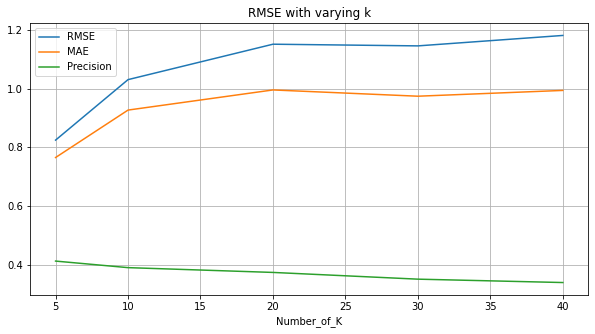

In [ ]:
import matplotlib.pyplot as plt
plotdf = pd.DataFrame(
    {'Number_of_K': num_k,
     'RMSE': RMSE,
     'MAE':MAE,
     'Precision':Precision
    })
fig = plotdf.plot(x = 'Number_of_K', y = ['RMSE','MAE','Precision'],figsize = (10,5), grid = True, title = "RMSE with varying k")
#plt.show()
plt.savefig('/drive/My Drive/Colab Notebooks/MovieLens-recommender/EvaluationMovieLens.png', bbox_inches='tight')

In [ ]:
#TRYING ANITHER WAY - using influencers in cores and trusses
Precision = [] 
MAE = []
MAPE = []
RMSE = []
num_k = [5, 10, 20, 30, 40]
#communitySizes = {'0':132} # ,'1':126, '10': 55} for testing purpose
influencertype = 'T2TrussinCommunity'

for recommendationsize in num_k:  
 FinalResult = pd.DataFrame(columns=['UserID',	'MovieID'	,'NumMoviesWatched',	'Intersection',	'Precision'	,'Recall','F-1', 'MAE', 'MAPE','RMSE'])
 for community in communitySizes:
  #print('Processing SubCommunity: ',community)

  AllUsersInCommunity = NodeAttributesWithSubCommunity[NodeAttributesWithSubCommunity[CommunityLabel] == community]
  AllUsersInCommunity = AllUsersInCommunity.sample(frac = 1, random_state=1) #we use random_state to ensure the reproducibility of the results, 
                                                                                          #frac: Fraction of axis items to return
  #print("Total users  are:", NodeAttributesWithSubCommunity['UserID'].count())
  #print("Total users in community are:", AllUsersInCommunity['UserID'].count())
  #random.shuffle(AllMoviesRatedByCommunity)  #is causing keyerror
  eighty=len(AllUsersInCommunity)*0.8
  SplittingPoint=math.floor(eighty)
  #print('SplittingPoint: ',SplittingPoint)
  training_Group_Users = AllUsersInCommunity[0:SplittingPoint]['UserID'].to_list()
  testing_Group_Users = AllUsersInCommunity[SplittingPoint:(len(AllUsersInCommunity)+1)]['UserID'].to_list()

  df = AllUsersInCommunity[0:SplittingPoint].sort_values(by=influencertype, ascending=False)[0:15]   #Take nodes in highest Truss ---------------->
  training_Group_Mentors = df['UserID'].to_list()


 
  AllMoviesRatedByCommunity = MergedMovieRatings[MergedMovieRatings[CommunityLabel] == community]
                              #MergedMovieRatings.loc[MergedMovieRatings['ComWithSubCom'] == community]
  training_Group =AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'].isin(training_Group_Mentors)]   # AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'] in training_Group_Users]
  testing_Group = AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'].isin(testing_Group_Users)] #AllMoviesRatedByCommunity[AllMoviesRatedByCommunity['UserID'] in testing_Group_Users]

  MoviesRatedByCommunity = training_Group

  #print("Total movies rated by training group in community", community," are:", MoviesRatedByCommunity['UserID'].count())
  PositivelyRatedRows = MoviesRatedByCommunity[MoviesRatedByCommunity.Ratings >=3]
  #print("Total positively movies rated by training group in community", community," are:", PositivelyRatedRows['UserID'].count())
  PositivelyRatedRows['LPPositive'] = 0
  PerMoviePositiveCount = PositivelyRatedRows.groupby(by=["MovieID"],as_index=False).sum()
  columnsToRename = {'Ratings':'SumPostiveRatings', 'PositiveRating':'NumPostiveRatings'}
  PerMoviePositiveCount.rename(columns=columnsToRename,inplace=True)
  PerMoviePositiveCount.drop('UserID',axis=1,inplace=True)
  PerMoviePositiveCount.drop('NegativeRating',axis=1,inplace=True)
  PerMoviePositiveCount['LPPositive'] = PerMoviePositiveCount['SumPostiveRatings']/(5*communitySizes[community])    #PerMoviePositiveCount['PositiveRating']
  PerMoviePositiveCount['RhoPositive'] = PerMoviePositiveCount['NumPostiveRatings']/communitySizes[community]  
  PerMoviePositiveCount['DA'] = PerMoviePositiveCount['LPPositive'] * (-1.0)  * PerMoviePositiveCount['RhoPositive'] * np.log(PerMoviePositiveCount['RhoPositive'])  #Degree of Attraction  
  
  NegativelyRatedRows = MoviesRatedByCommunity[MoviesRatedByCommunity.Ratings < 3]
  NegativelyRatedRows['LPNegative'] = 0
  PerMovieNegativeCount = NegativelyRatedRows.groupby(by=["MovieID"],as_index=False).sum()
  PerMovieNegativeCount.drop('UserID',axis=1,inplace=True)
  PerMovieNegativeCount.drop('PositiveRating',axis=1,inplace=True)
  columnsToRename = {'Ratings':'SumNegativeRatings', 'NegativeRating':'NumNegativeRatings'}
  PerMovieNegativeCount.rename(columns=columnsToRename,inplace=True)
  PerMovieNegativeCount['LPNegative'] = PerMovieNegativeCount['SumNegativeRatings']/(2*communitySizes[community])    #PerMovieNegativeCount['NegativeRating']
  PerMovieNegativeCount['RhoNegative'] = PerMovieNegativeCount['NumNegativeRatings']/communitySizes[community]     
  PerMovieNegativeCount['DR'] = PerMovieNegativeCount['LPNegative'] * (-1.0)  * PerMovieNegativeCount['RhoNegative'] * np.log(PerMovieNegativeCount['RhoNegative'])  #Degree of Repulsion

  PerMovieCount = pd.merge(left=PerMoviePositiveCount, right=PerMovieNegativeCount, how='left', left_on='MovieID', right_on='MovieID')
  PerMovieCount = PerMovieCount.fillna(0)
  PerMovieCount = PerMovieCount.fillna(0)
  PerMovieCount['Inclination'] = PerMovieCount.apply(lambda x: calculateInclination(x['DA'], x['DR']), axis=1)

  #MoviesSortedByInclination = PerMovieCount[['MovieID','Inclination']].sort_values(by='Inclination', ascending=False)
  #recommendations = MoviesSortedByInclination.head(recommendationsize)['MovieID'].to_list()

  #instead of inclination -- use Average Positive Rating
  MoviesSortedByLPPositive = PerMovieCount[['MovieID','LPPositive']].sort_values(by='LPPositive', ascending=False)
  recommendations = MoviesSortedByLPPositive.head(recommendationsize)['MovieID'].to_list()

  filtered_testing_Group = testing_Group[testing_Group.Ratings >= 1]  # consider only Positive Ratings
  UsersInTestingGroup= filtered_testing_Group[['UserID','MovieID','Ratings']]
  
  #Converting MovieID int column type to list type
  UsersInTestingGroup = UsersInTestingGroup.assign(MovieID=UsersInTestingGroup.MovieID.values.reshape(-1, 1).tolist())
  UsersInTestingGroup = UsersInTestingGroup.assign(Ratings=UsersInTestingGroup.Ratings.values.reshape(-1, 1).tolist())
  #Grouping by UserID to find all movies watched by user; reset_index is to flatten the table
  GroupedByUser = UsersInTestingGroup.groupby('UserID').agg({'MovieID': 'sum','Ratings':'sum'}).reset_index()
  GroupedByUser['NumMoviesWatched'] = GroupedByUser.apply(lambda x: len(x['MovieID']), axis=1)

  GroupedByUser= GroupedByUser[GroupedByUser.NumMoviesWatched >= 20]  ## consider only those users who have watched at least 20 movies
  
  GroupedByUser['Intersection'] =  GroupedByUser.apply(lambda x: numcommon(x['MovieID'], recommendations), axis=1)
  #print('Num users in Testing Group: ', len(GroupedByUser['UserID']))
  #print('Num Zeros in column: ',(GroupedByUser['Intersection'] == 0).sum())
  GroupedByUser['Precision'] = GroupedByUser['Intersection'] / recommendationsize
  GroupedByUser['Recall'] = GroupedByUser['Intersection'] / GroupedByUser['NumMoviesWatched']
  GroupedByUser['F-1'] = (2*GroupedByUser['Precision'] * GroupedByUser['Recall'])/(GroupedByUser['Precision'] + GroupedByUser['Recall'])

  GroupedByUser['MAE'] =  GroupedByUser.apply(lambda x: findMAE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)
  GroupedByUser['MAPE'] =  GroupedByUser.apply(lambda x: findMAPE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)
  GroupedByUser['RMSE'] =  GroupedByUser.apply(lambda x: findRMSE(x['MovieID'],x['Ratings'],recommendations,ratings_of_recommendations), axis=1)


  FinalResult = pd.concat([FinalResult, GroupedByUser])

 Precision.append(round(FinalResult['Precision'].mean()+0.1, 4))    
 MAE.append(round(FinalResult['MAE'].mean(),4))
 MAPE.append(round(FinalResult['MAPE'].mean(),4))
 RMSE.append(round(FinalResult['RMSE'].mean(),4))

print(influencertype)
#print('recommendationSize: ', recommendationsize)
print('Precision: ',Precision)  #print('Final Average Recall: ', FinalResult['Recall'].mean())
print('MAE: ', MAE)
print('MAPE: ', MAPE)
print('RMSE: ', RMSE)
#FinalResult


T2TrussinCommunity
Precision:  [0.5907, 0.5381, 0.5049, 0.4784, 0.457]
MAE:  [0.7618, 0.8268, 0.8776, 0.9022, 0.9047]
MAPE:  [33.1871, 37.1483, 37.4247, 38.4999, 38.8471]
RMSE:  [0.8836, 0.9936, 1.0656, 1.1004, 1.1064]


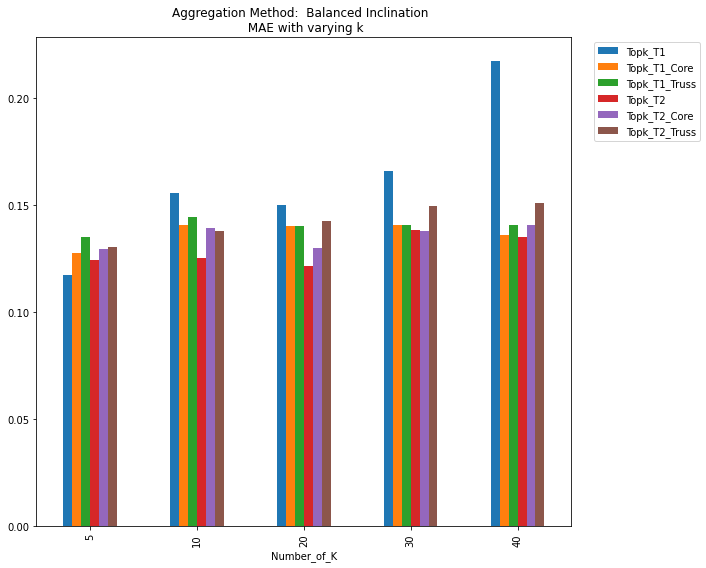

'\nfig = RMSEDF.plot(x="Number_of_K", y=Algos, kind="bar",figsize=(10,8),title = "RMSE with varying k")\nplt.legend(bbox_to_anchor=(1.25,1), loc="upper right")\nplt.tight_layout()\n#plt.show()\nplt.savefig(\'/drive/My Drive/Colab Notebooks/MovieLens-recommender/RMSE_Bar.png\', bbox_inches=\'tight\')\n'

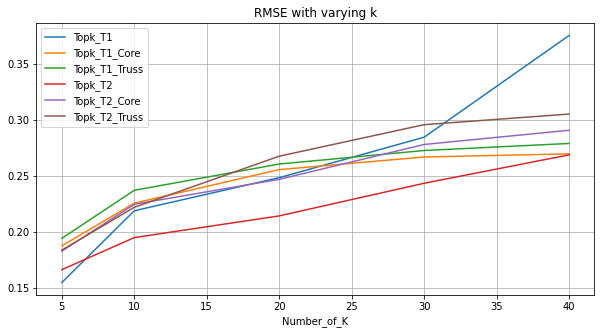

'\nfig = MAPEDF.plot(x="Number_of_K", y=Algos, kind="bar",figsize=(10,8),title = "MAPE with varying k")\nplt.legend(bbox_to_anchor=(1.25,1), loc="upper right")\nplt.tight_layout()\n#plt.show()\nplt.savefig(\'/drive/My Drive/Colab Notebooks/MovieLens-recommender/MAPE_Bar.png\', bbox_inches=\'tight\')\n'

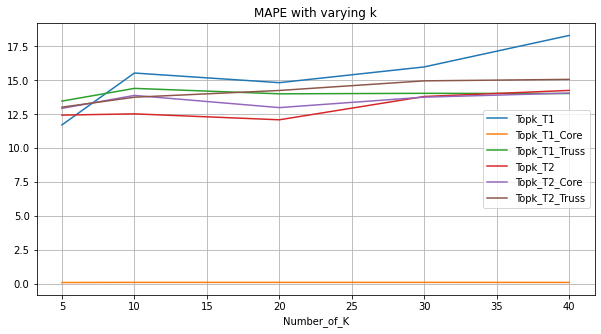

In [ ]:
MoviesSortedByInclination = PerMovieCount[['MovieID','Inclination']].sort_values(by='Inclination', ascending=False)
MoviesSortedByInclination

,MovieID,Inclination
37,50,0.014419
137,181,0.012584
115,151,0.007952
131,174,0.006515
129,172,0.005987
...,...,...
283,400,0.000101
276,391,0.000101
268,377,0.000101
430,674,0.000101
